<a href="https://colab.research.google.com/github/metehan-karaca/material_identification/blob/main/Testing_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from PIL import Image

import numpy as np
import os
from google.colab import drive

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import seaborn as sns

# Mount Google Drive!


In [ ]:
# !unrar x "/content/drive/MyDrive/senior-project/Senior Project.rar" -d "/content/drive/MyDrive/senior-project"

In [ ]:


# Path to the saved model and the folder containing images
model_path = '/content/drive/MyDrive/senior-project/cnn-models/model-functionalApi3-e100'
validation_path = '/content/drive/MyDrive/senior-project/dataset-val'


['Amoledscreen-1B', 'concrete-1A', 'concrete-1B', 'Cooper-1A', 'Copper-1B', 'denimfabric-1A', 'denimfabric-1B', 'fabric-1A', 'fabric-1B', 'faux-leather-1A', 'faux-leather-1B', 'Granite-1A', 'Granite-1B', 'LCDscreen-1B', 'Paper(not scratched)-1B', 'Plastic1-A', 'Plastic1-B', 'Plastic2-A', 'Plastic2-B', 'satinfabric-1A', 'satinfabric-1B', 'Scratchedpaper-1B', 'Spandexfabric-1B', 'Spandexfabric1-A', 'Steel-1A', 'Steel-1B', 'Steel-alloy mixture1-A', 'Steel-alloy mixture1-B', 'Teflon-1A', 'Teflon-1B', 'velvetfabric1-A', 'velvetrabric1-B', 'Wood- 3B', 'wood-1A', 'wood-1B', 'Wood-2 B', 'Wood-2A', 'Wood-2B', 'Wood-3A', 'Wood-3B', 'Wood-4A', 'Wood-4B', 'Wood-5A', 'Wood-5B']


In [ ]:
#a function to display dataset

def display_dataset_summary(dataset_path):

    # Initialize data structures
    categories = []
    image_counts = []
    sample_images = []

    # Walk through the dataset directory structure
    for dirpath, dirnames, filenames in os.walk(dataset_path):
        if dirpath != dataset_path:  # Check to avoid the root directory itself
            categories.append(os.path.basename(dirpath))
            image_counts.append(len(filenames))
            # Randomly pick an image for display as a thumbnail
            sample_image_path = os.path.join(dirpath, np.random.choice(filenames))
            image = Image.open(sample_image_path)
            image.thumbnail((128, 128))  # Resize to thumbnail
            sample_images.append(image)

    # Determine the number of rows and columns for the subplot grid
    n_cols = 5  # You can adjust this number based on your preference
    n_rows = (len(categories) + n_cols - 1) // n_cols  # Ensures enough rows are available

    # Plotting
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 2 * n_rows))
    axs = axs.flatten()  # Flatten the array to make iteration easier

    for idx, ax in enumerate(axs):
        if idx < len(categories):
            ax.imshow(sample_images[idx])
            ax.axis('off')  # Turn off axis
            ax.set_title(f"{categories[idx]}\nCount: {image_counts[idx]}")
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()
    plt.show()




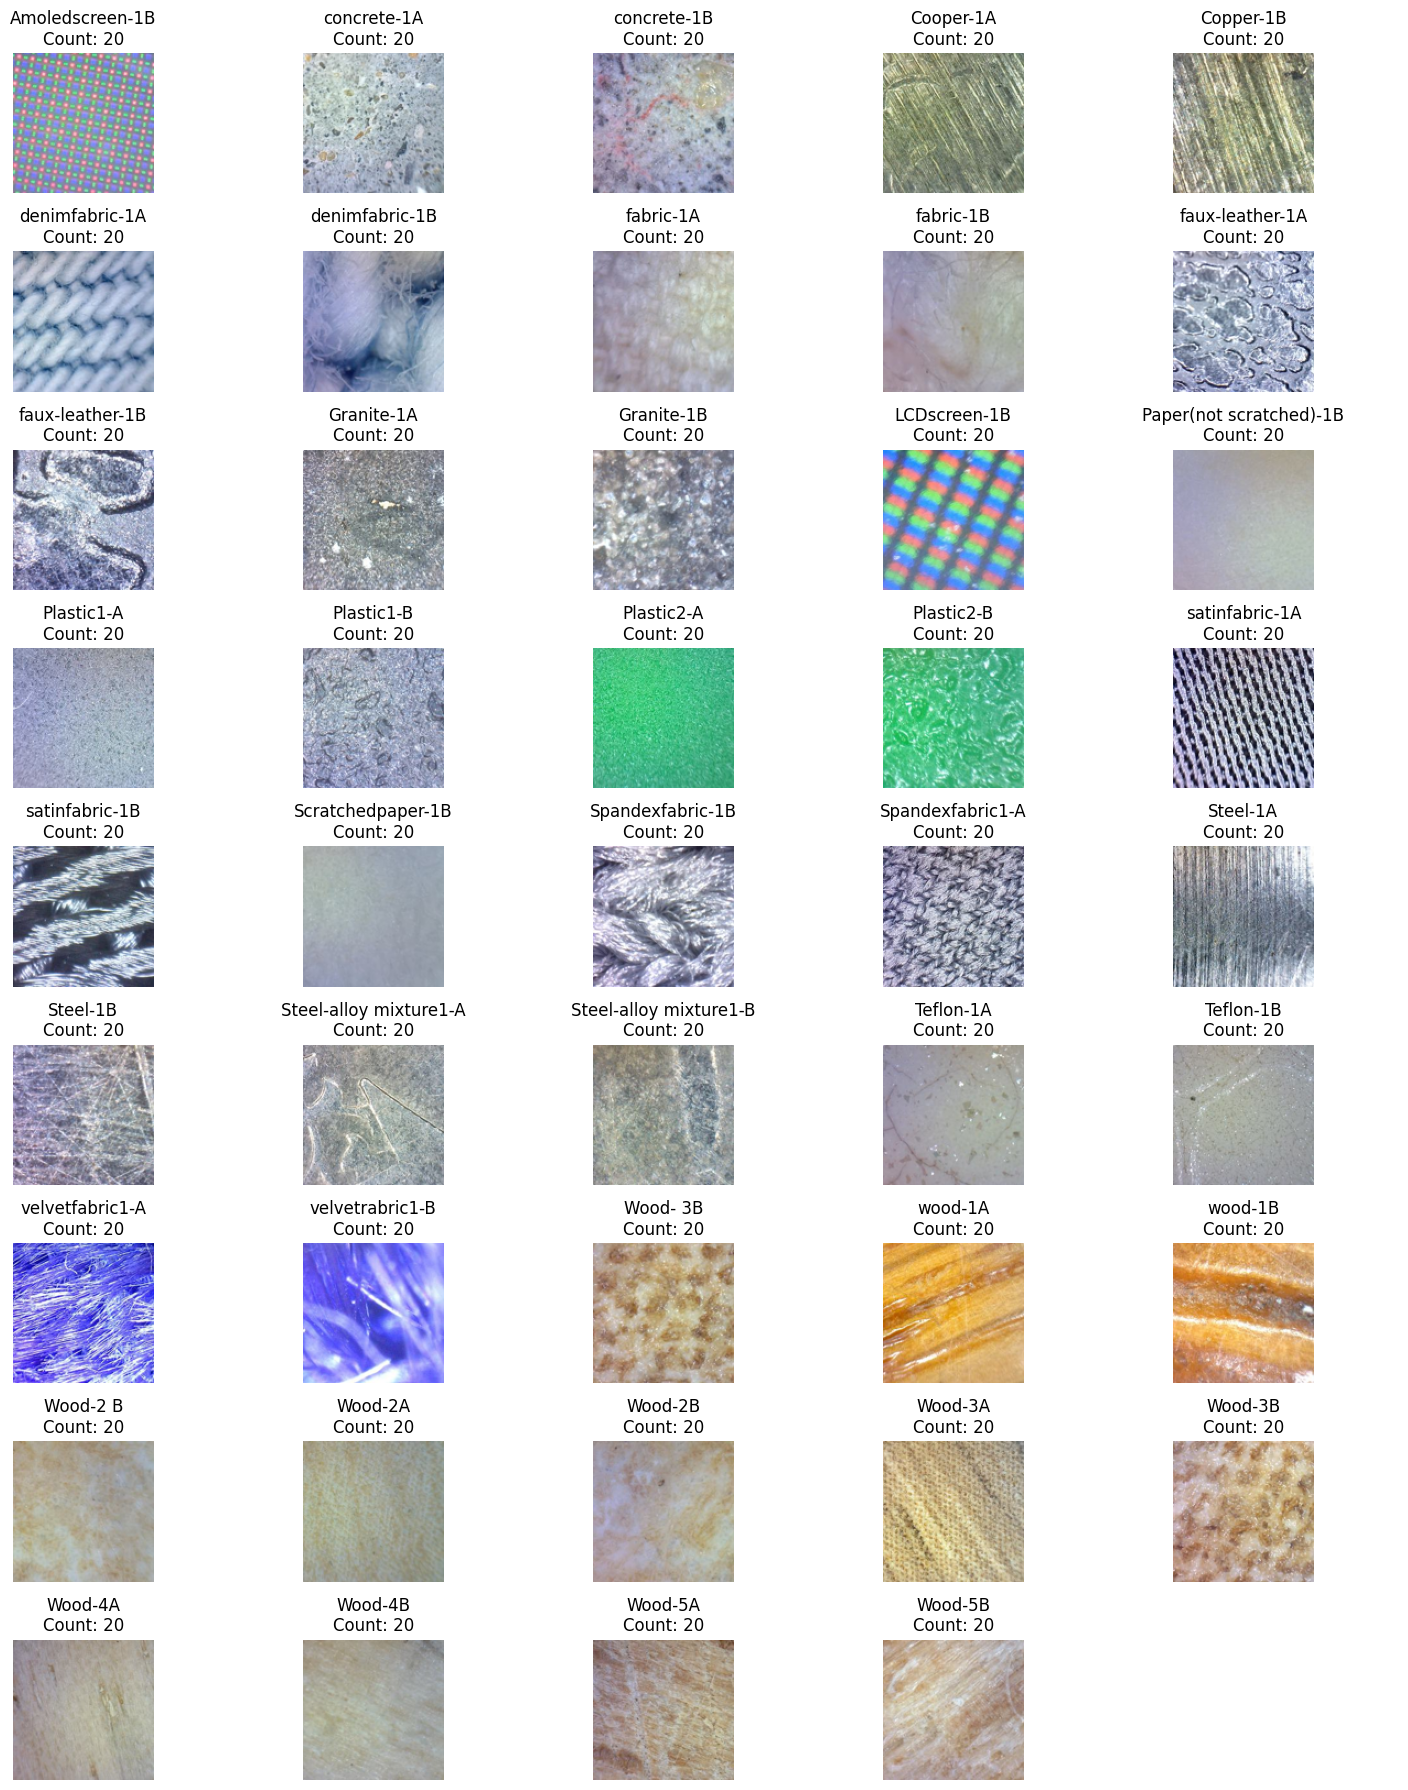

In [ ]:

display_dataset_summary(validation_path)


In [ ]:

# Load the model
model = load_model(model_path)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 200, 150, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 200, 150, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 200, 150, 32)         0         ['batch_normalization[0][0

In [ ]:
model_shape = model.input_shape
print(model_shape)

(None, 200, 150, 3)


In [ ]:

# Preprocess images
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(model_shape[1], model_shape[2]))  # Change target_size to the input size of your model
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.0  # Assuming your model uses this normalization
    return img_tensor


In [ ]:
def random_img_test(validation_path):
    # Create a data generator for the validation data
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Prepare the data generator
    test_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(model_shape[1], model_shape[2]),
        batch_size=1,  # Batch size set to 1 to process one image at a time
        class_mode='categorical',
        shuffle=True  # Shuffle to get different results each run
    )

    # Function to plot the image and prediction
    def plot_image_prediction(image, predicted_label, true_label):
        plt.imshow(image)
        plt.title(f'Predicted: {predicted_label}\nTrue: {true_label}')
        plt.axis('off')
        plt.show()

    # Fetch a random image and its label
    image_batch, label_batch = next(test_generator)  # This fetches the next batch

    # Make a prediction
    prediction = model.predict(image_batch)
    predicted_class_index = np.argmax(prediction)
    predicted_class = list(test_generator.class_indices.keys())[predicted_class_index]
    true_class_index = np.argmax(label_batch)
    true_class = list(test_generator.class_indices.keys())[true_class_index]

    # Display the image and prediction
    plot_image_prediction(image_batch[0], predicted_class, true_class)

In [ ]:
random_img_test(validation_path)

NameError: name 'random_img_test' is not defined

Found 880 images belonging to 44 classes.
28/28 [==============================] - 5s 174ms/step


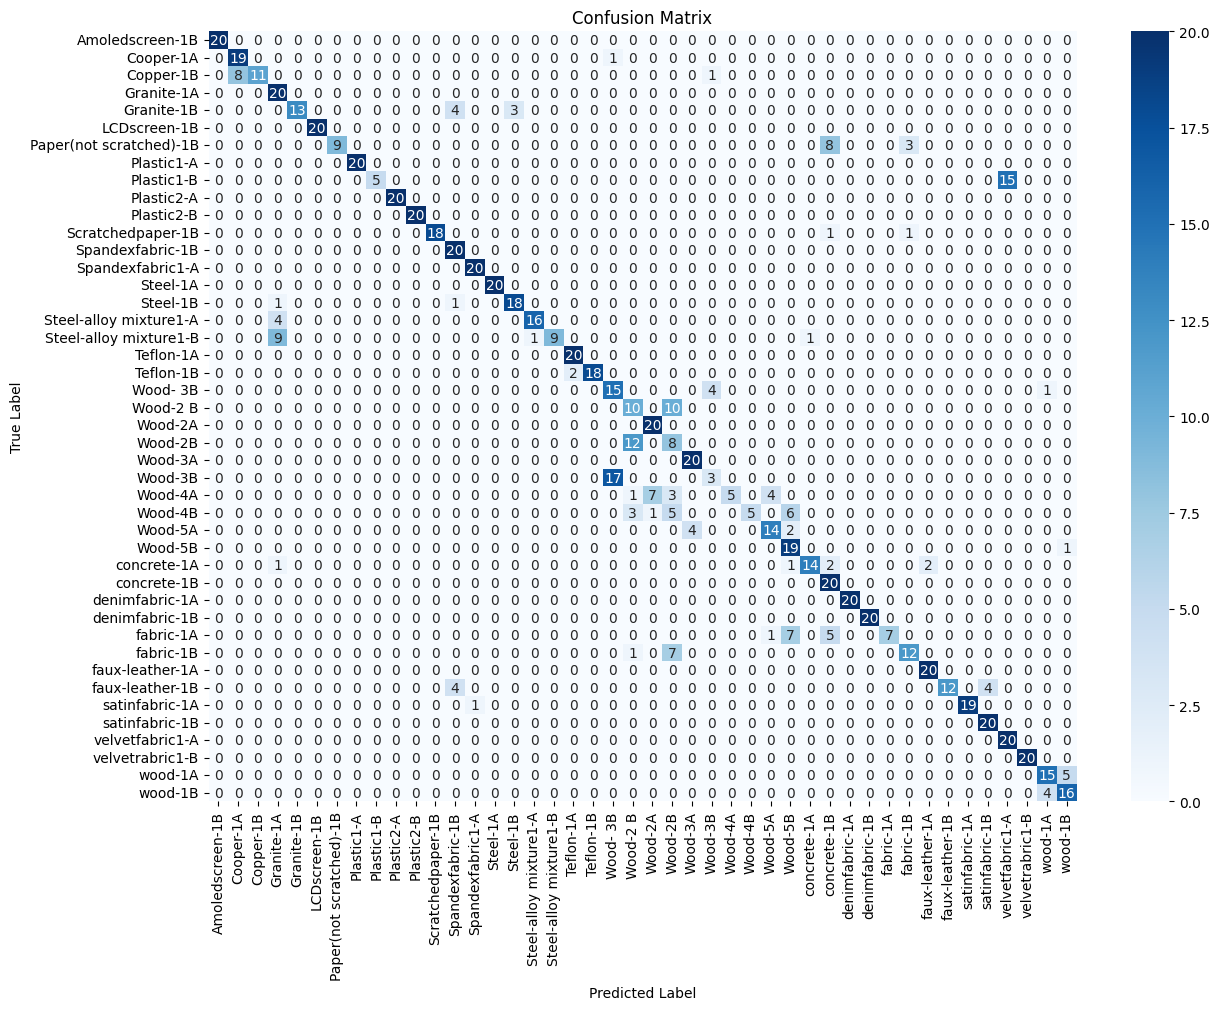

In [ ]:
def test_model_and_plot_confusion_matrix(model_path, test_dir, batch_size=32):
    """
    Load a model, preprocess images, predict classes, and plot a confusion matrix.

    Args:
    model_path (str): Path to the saved Keras model.
    test_dir (str): Directory with test images, organized in subdirectories named after their classes.
    target_size (tuple): Tuple (height, width) expected by the model.
    batch_size (int): Number of images to process in each batch.
    """
    # Load the model
    model = load_model(model_path)

    # Create a data generator for the test images
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(model.input_shape[1], model.input_shape[2]),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)  # Important to keep in order for matching predictions to labels

    # Predict the whole generator to get predictions
    predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size))
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true classes
    true_classes = test_generator.classes

    # Class labels
    class_labels = list(test_generator.class_indices.keys())

    # Compute confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    # Plotting the confusion matrix
    plt.figure(figsize=(14, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


test_model_and_plot_confusion_matrix(model_path, validation_path)


Found 880 images belonging to 44 classes.
28/28 [==============================] - 3s 118ms/step


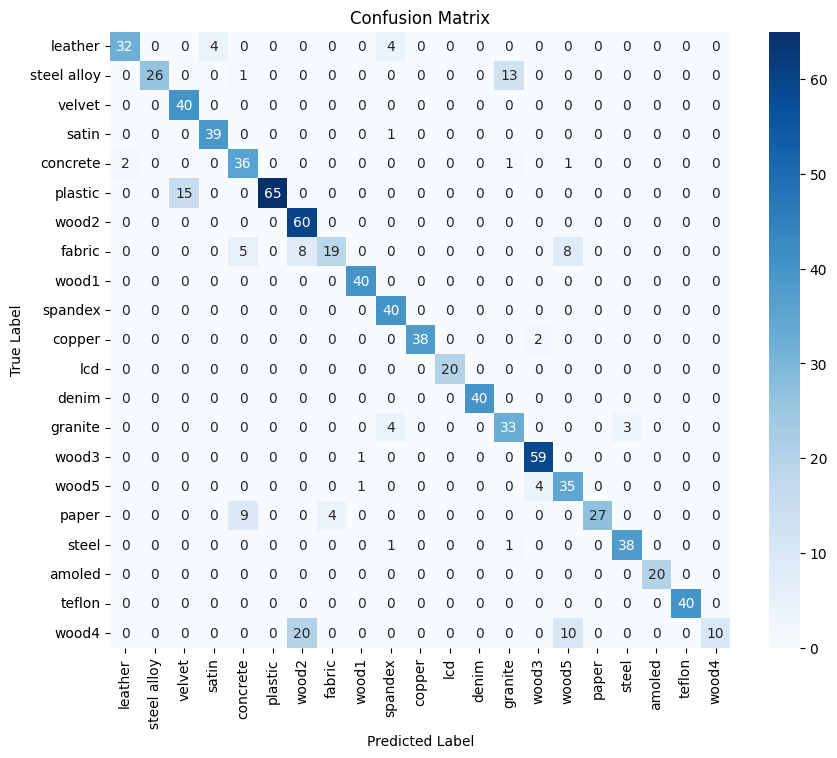

In [ ]:
def test_confusion_matrix_merged_AB(model_path, test_dir, class_mapping=None, batch_size=32):
    """
    Load a model, preprocess images, predict classes, and plot a confusion matrix with merged classes.

    Args:
    model_path (str): Path to the saved Keras model.
    test_dir (str): Directory with test images, organized in subdirectories named after their classes.
    class_mapping (dict): Dictionary to map original classes to new merged classes.
    batch_size (int): Number of images to process in each batch.
    """
    from keras.preprocessing.image import ImageDataGenerator
    from keras.models import load_model
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    # Load the model
    model = load_model(model_path)

    # Create a data generator for the test images
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(model.input_shape[1], model.input_shape[2]),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    # Predict the whole generator to get predictions
    predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size))
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true classes
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    if class_mapping:
        # Map both predicted and true classes to new classes based on the provided mapping
        merged_class_labels = list(set(class_mapping.values()))  # New class labels after merging
        true_classes = np.array([class_mapping[class_labels[c]] for c in true_classes])
        predicted_classes = np.array([class_mapping[class_labels[c]] for c in predicted_classes])

    # Compute confusion matrix with new class labels
    cm = confusion_matrix(true_classes, predicted_classes, labels=merged_class_labels)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=merged_class_labels, yticklabels=merged_class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Example of how to call the function
class_mapping = {'Amoledscreen-1B': 'amoled', 'concrete-1A': 'concrete', 'concrete-1B': 'concrete',
                 'Cooper-1A': 'copper', 'Copper-1B': 'copper', 'denimfabric-1A': 'denim',
                 'denimfabric-1B': 'denim', 'fabric-1A': 'fabric', 'fabric-1B': 'fabric', 'faux-leather-1A': 'leather', 'faux-leather-1B': 'leather',
                 'Granite-1A': 'granite', 'Granite-1B': 'granite', 'LCDscreen-1B': 'lcd', 'Paper(not scratched)-1B': 'paper',
                 'Plastic1-A': 'plastic', 'Plastic1-B': 'plastic', 'Plastic2-A': 'plastic', 'Plastic2-B': 'plastic', 'satinfabric-1A': 'satin',
                 'satinfabric-1B': 'satin', 'Scratchedpaper-1B': 'paper', 'Spandexfabric-1B': 'spandex', 'Spandexfabric1-A': 'spandex',
                 'Steel-1A': 'steel', 'Steel-1B': 'steel', 'Steel-alloy mixture1-A': 'steel alloy', 'Steel-alloy mixture1-B': 'steel alloy',
                 'Teflon-1A': 'teflon', 'Teflon-1B': 'teflon', 'velvetfabric1-A': 'velvet', 'velvetrabric1-B': 'velvet', 'Wood- 3B': 'wood3',
                 'wood-1A': 'wood1', 'wood-1B': 'wood1', 'Wood-2 B': 'wood2', 'Wood-2A': 'wood2', 'Wood-2B': 'wood2', 'Wood-3A': 'wood3', 'Wood-3B': 'wood3',
                 'Wood-4A': 'wood4', 'Wood-4B': 'wood4', 'Wood-5A': 'wood5', 'Wood-5B': 'wood5'}

test_confusion_matrix_merged_AB(model_path, validation_path, class_mapping)


Found 880 images belonging to 44 classes.
28/28 [==============================] - 4s 121ms/step


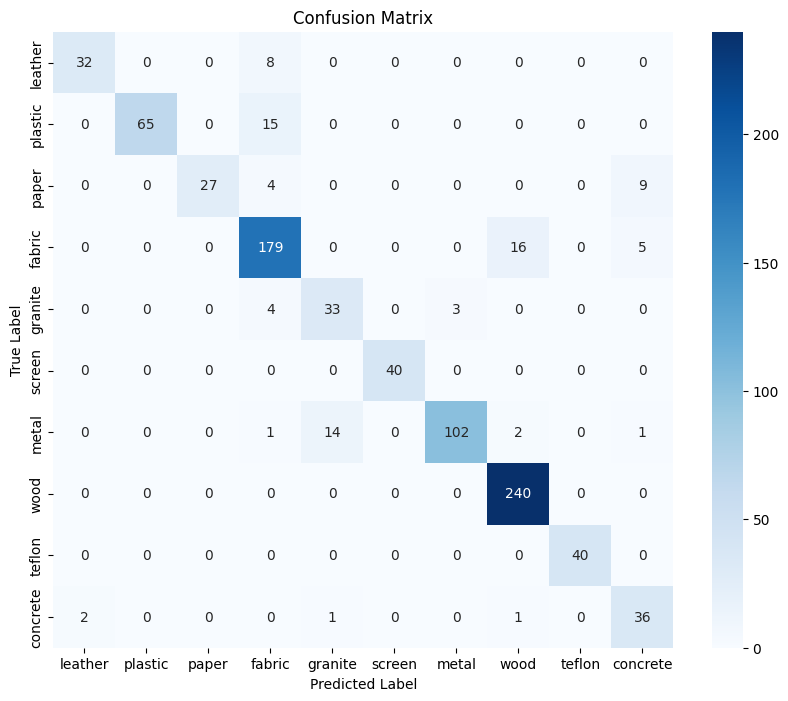

In [ ]:
def test_confusion_matrix_merged(model_path, test_dir, class_mapping=None, batch_size=32):
    """
    Load a model, preprocess images, predict classes, and plot a confusion matrix with merged classes.

    Args:
    model_path (str): Path to the saved Keras model.
    test_dir (str): Directory with test images, organized in subdirectories named after their classes.
    class_mapping (dict): Dictionary to map original classes to new merged classes.
    batch_size (int): Number of images to process in each batch.
    """
    from keras.preprocessing.image import ImageDataGenerator
    from keras.models import load_model
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    # Load the model
    model = load_model(model_path)

    # Create a data generator for the test images
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(model.input_shape[1], model.input_shape[2]),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    # Predict the whole generator to get predictions
    predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size))
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true classes
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    if class_mapping:
        # Map both predicted and true classes to new classes based on the provided mapping
        merged_class_labels = list(set(class_mapping.values()))  # New class labels after merging
        true_classes = np.array([class_mapping[class_labels[c]] for c in true_classes])
        predicted_classes = np.array([class_mapping[class_labels[c]] for c in predicted_classes])

    # Compute confusion matrix with new class labels
    cm = confusion_matrix(true_classes, predicted_classes, labels=merged_class_labels)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=merged_class_labels, yticklabels=merged_class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Example of how to call the function
class_mapping = {'Amoledscreen-1B': 'screen', 'concrete-1A': 'concrete', 'concrete-1B': 'concrete',
                 'Cooper-1A': 'metal', 'Copper-1B': 'metal', 'denimfabric-1A': 'fabric',
                 'denimfabric-1B': 'fabric', 'fabric-1A': 'fabric', 'fabric-1B': 'fabric', 'faux-leather-1A': 'leather', 'faux-leather-1B': 'leather',
                 'Granite-1A': 'granite', 'Granite-1B': 'granite', 'LCDscreen-1B': 'screen', 'Paper(not scratched)-1B': 'paper',
                 'Plastic1-A': 'plastic', 'Plastic1-B': 'plastic', 'Plastic2-A': 'plastic', 'Plastic2-B': 'plastic', 'satinfabric-1A': 'fabric',
                 'satinfabric-1B': 'fabric', 'Scratchedpaper-1B': 'paper', 'Spandexfabric-1B': 'fabric', 'Spandexfabric1-A': 'fabric',
                 'Steel-1A': 'metal', 'Steel-1B': 'metal', 'Steel-alloy mixture1-A': 'metal', 'Steel-alloy mixture1-B': 'metal',
                 'Teflon-1A': 'teflon', 'Teflon-1B': 'teflon', 'velvetfabric1-A': 'fabric', 'velvetrabric1-B': 'fabric', 'Wood- 3B': 'wood',
                 'wood-1A': 'wood', 'wood-1B': 'wood', 'Wood-2 B': 'wood', 'Wood-2A': 'wood', 'Wood-2B': 'wood', 'Wood-3A': 'wood', 'Wood-3B': 'wood',
                 'Wood-4A': 'wood', 'Wood-4B': 'wood', 'Wood-5A': 'wood', 'Wood-5B': 'wood'}

test_confusion_matrix_merged(model_path, validation_path, class_mapping)


In [ ]:

#class_ab = {item: "abc" for item in os.listdir("/content/drive/MyDrive/senior-project/dataset-val")}
#print(class_ab)

{'Amoledscreen-1B': 'abc', 'concrete-1A': 'abc', 'concrete-1B': 'abc', 'Cooper-1A': 'abc', 'Copper-1B': 'abc', 'denimfabric-1A': 'abc', 'denimfabric-1B': 'abc', 'fabric-1A': 'abc', 'fabric-1B': 'abc', 'faux-leather-1A': 'abc', 'faux-leather-1B': 'abc', 'Granite-1A': 'abc', 'Granite-1B': 'abc', 'LCDscreen-1B': 'abc', 'Paper(not scratched)-1B': 'abc', 'Plastic1-A': 'abc', 'Plastic1-B': 'abc', 'Plastic2-A': 'abc', 'Plastic2-B': 'abc', 'satinfabric-1A': 'abc', 'satinfabric-1B': 'abc', 'Scratchedpaper-1B': 'abc', 'Spandexfabric-1B': 'abc', 'Spandexfabric1-A': 'abc', 'Steel-1A': 'abc', 'Steel-1B': 'abc', 'Steel-alloy mixture1-A': 'abc', 'Steel-alloy mixture1-B': 'abc', 'Teflon-1A': 'abc', 'Teflon-1B': 'abc', 'velvetfabric1-A': 'abc', 'velvetrabric1-B': 'abc', 'Wood- 3B': 'abc', 'wood-1A': 'abc', 'wood-1B': 'abc', 'Wood-2 B': 'abc', 'Wood-2A': 'abc', 'Wood-2B': 'abc', 'Wood-3A': 'abc', 'Wood-3B': 'abc', 'Wood-4A': 'abc', 'Wood-4B': 'abc', 'Wood-5A': 'abc', 'Wood-5B': 'abc'}


In [ ]:

def evaluate_model_accuracy(model_path, test_dir, batch_size=32):
    """
    Load a model and evaluate it on a test dataset, reporting accuracy, precision, recall, and F1-score.

    Args:
    model_path (str): Path to the saved Keras model.
    test_dir (str): Directory with test images, organized in subdirectories named after their classes.
    target_size (tuple): Tuple (height, width) expected by the model.
    batch_size (int): Number of images to process in each batch.

    Returns:
    dict: A dictionary containing accuracy, precision, recall, and F1-score.
    """
    # Load the model
    model = load_model(model_path)

    # Create a data generator for the test images
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(model.input_shape[1], model.input_shape[2]),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)  # don't change for matching predictions to labels

    # Predict the whole generated images
    predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size))
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true classes
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Calculate metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    f1 = f1_score(true_classes, predicted_classes, average='weighted')

    # Generate a full classification report
    full_report = classification_report(true_classes, predicted_classes, target_names=class_labels)

    # Print the full classification report
    print(full_report)

    # Return a dictionary of the computed metrics
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }


In [ ]:


#run evaluation
metrics = evaluate_model_accuracy(model_path, validation_path)
print(metrics)


Found 880 images belonging to 44 classes.
28/28 [==============================] - 3s 119ms/step
                         precision    recall  f1-score   support

        Amoledscreen-1B       1.00      1.00      1.00        20
              Cooper-1A       0.70      0.95      0.81        20
              Copper-1B       1.00      0.55      0.71        20
             Granite-1A       0.57      1.00      0.73        20
             Granite-1B       1.00      0.65      0.79        20
           LCDscreen-1B       1.00      1.00      1.00        20
Paper(not scratched)-1B       1.00      0.45      0.62        20
             Plastic1-A       1.00      1.00      1.00        20
             Plastic1-B       1.00      0.25      0.40        20
             Plastic2-A       1.00      1.00      1.00        20
             Plastic2-B       1.00      1.00      1.00        20
      Scratchedpaper-1B       1.00      0.90      0.95        20
       Spandexfabric-1B       0.69      1.00      0.82   

In [ ]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

def evaluate_model_accuracy_merged(model_path, test_dir, class_mapping=None, batch_size=32):
    """
    Load a model and evaluate it on a test dataset with optional class merging, reporting accuracy, precision, recall, and F1-score.

    Args:
    model_path (str): Path to the saved Keras model.
    test_dir (str): Directory with test images, organized in subdirectories named after their classes.
    class_mapping (dict): Optional dictionary to map original classes to new merged classes.
    batch_size (int): Number of images to process in each batch.

    Returns:
    dict: A dictionary containing accuracy, precision, recall, and F1-score.
    """
    # Load the model
    model = load_model(model_path)

    # Create a data generator for the test images
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(model.input_shape[1], model.input_shape[2]),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    # Predict the whole generated images
    predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size))
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    if class_mapping:
        # Remap the true_classes and predicted_classes based on the class_mapping
        reverse_mapping = {v: k for k, v in test_generator.class_indices.items()}
        new_class_labels = list(set(class_mapping.values()))
        class_indices = {new_label: idx for idx, new_label in enumerate(new_class_labels)}

        # Remapping true and predicted classes
        remap = lambda classes: np.array([class_indices[class_mapping[reverse_mapping[c]]] for c in classes])
        true_classes = remap(true_classes)
        predicted_classes = remap(predicted_classes)
        class_labels = new_class_labels

    # Calculate metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted', zero_division=0)
    recall = recall_score(true_classes, predicted_classes, average='weighted', zero_division=0)
    f1 = f1_score(true_classes, predicted_classes, average='weighted', zero_division=0)

    # Generate a full classification report
    full_report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

    # Print the full classification report
    print(full_report)

    # Return a dictionary of the computed metrics
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Example usage
class_mapping = {'Amoledscreen-1B': 'screen', 'concrete-1A': 'concrete', 'concrete-1B': 'concrete',
                 'Cooper-1A': 'metal', 'Copper-1B': 'metal', 'denimfabric-1A': 'fabric',
                 'denimfabric-1B': 'fabric', 'fabric-1A': 'fabric', 'fabric-1B': 'fabric', 'faux-leather-1A': 'leather', 'faux-leather-1B': 'leather',
                 'Granite-1A': 'granite', 'Granite-1B': 'granite', 'LCDscreen-1B': 'screen', 'Paper(not scratched)-1B': 'paper',
                 'Plastic1-A': 'plastic', 'Plastic1-B': 'plastic', 'Plastic2-A': 'plastic', 'Plastic2-B': 'plastic', 'satinfabric-1A': 'fabric',
                 'satinfabric-1B': 'fabric', 'Scratchedpaper-1B': 'paper', 'Spandexfabric-1B': 'fabric', 'Spandexfabric1-A': 'fabric',
                 'Steel-1A': 'metal', 'Steel-1B': 'metal', 'Steel-alloy mixture1-A': 'metal', 'Steel-alloy mixture1-B': 'metal',
                 'Teflon-1A': 'teflon', 'Teflon-1B': 'teflon', 'velvetfabric1-A': 'fabric', 'velvetrabric1-B': 'fabric', 'Wood- 3B': 'wood',
                 'wood-1A': 'wood', 'wood-1B': 'wood', 'Wood-2 B': 'wood', 'Wood-2A': 'wood', 'Wood-2B': 'wood', 'Wood-3A': 'wood', 'Wood-3B': 'wood',
                 'Wood-4A': 'wood', 'Wood-4B': 'wood', 'Wood-5A': 'wood', 'Wood-5B': 'wood'}
evaluate_model_accuracy_merged(model_path, validation_path, class_mapping)


Found 880 images belonging to 44 classes.
28/28 [==============================] - 4s 123ms/step
              precision    recall  f1-score   support

     leather       0.94      0.80      0.86        40
     plastic       1.00      0.81      0.90        80
       paper       1.00      0.68      0.81        40
      fabric       0.85      0.90      0.87       200
     granite       0.69      0.82      0.75        40
      screen       1.00      1.00      1.00        40
       metal       0.97      0.85      0.91       120
        wood       0.93      1.00      0.96       240
      teflon       1.00      1.00      1.00        40
    concrete       0.71      0.90      0.79        40

    accuracy                           0.90       880
   macro avg       0.91      0.88      0.88       880
weighted avg       0.91      0.90      0.90       880



{'accuracy': 0.9022727272727272,
 'precision': 0.9113816481271876,
 'recall': 0.9022727272727272,
 'f1_score': 0.9023600674239957}

Found 880 images belonging to 44 classes.
28/28 [==============================] - 4s 136ms/step


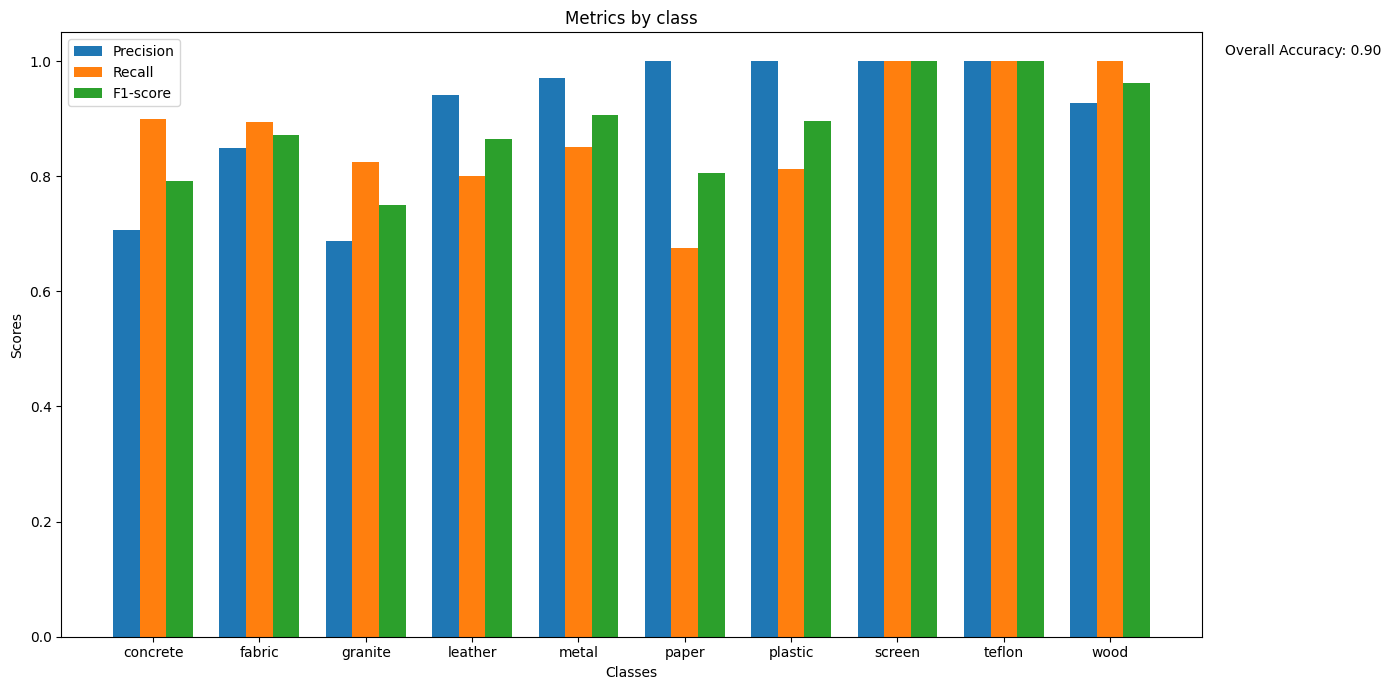

In [ ]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

def evaluate_and_plot_by_class(model_path, test_dir, class_mapping, batch_size=32):
    """
    Load a model, evaluate it with class merging, and plot F1-score, precision, and accuracy by class.

    Args:
    model_path (str): Path to the saved Keras model.
    test_dir (str): Directory with validation images, organized in subdirectories named after their classes.
    class_mapping (dict): Dictionary to map original classes to new merged classes.
    batch_size (int): Number of images to process in each batch.
    """
    # Load the model
    model = load_model(model_path)

    # Create a data generator for the validation images
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
        test_dir,
        target_size=(model.input_shape[1], model.input_shape[2]),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    # Predict the validation data
    predictions = model.predict(generator, steps=np.ceil(generator.samples / batch_size))
    predicted_classes = np.argmax(predictions, axis=1)

    # Map true classes
    true_classes = generator.classes
    label_map = {v: k for k, v in generator.class_indices.items()}
    true_labels = np.array([label_map[i] for i in true_classes])

    # Remap true and predicted classes according to class_mapping
    remapped_true_labels = np.array([class_mapping.get(label, label) for label in true_labels])
    remapped_predicted_labels = np.array([class_mapping.get(label_map[i], label_map[i]) for i in predicted_classes])

    # Get unique class labels after mapping
    unique_classes = np.unique(remapped_true_labels)

    # Calculate metrics for each class
    precision, recall, f1, support = precision_recall_fscore_support(remapped_true_labels, remapped_predicted_labels, labels=unique_classes, average=None, zero_division=0)
    accuracy = accuracy_score(remapped_true_labels, remapped_predicted_labels)

    # Plot metrics
    x = np.arange(len(unique_classes))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(14, 7))
    rects1 = ax.bar(x - width, precision, width, label='Precision')
    rects2 = ax.bar(x, recall, width, label='Recall')
    rects3 = ax.bar(x + width, f1, width, label='F1-score')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Classes')
    ax.set_ylabel('Scores')
    ax.set_title('Metrics by class')
    ax.set_xticks(x)
    ax.set_xticklabels(unique_classes)
    ax.legend()

    # Adding accuracy text
    ax.text(1.02, 0.98, f'Overall Accuracy: {accuracy:.2f}', transform=ax.transAxes, verticalalignment='top')

    fig.tight_layout()

    plt.show()

# Example usage

class_mapping = {'Amoledscreen-1B': 'screen', 'concrete-1A': 'concrete', 'concrete-1B': 'concrete',
                 'Cooper-1A': 'metal', 'Copper-1B': 'metal', 'denimfabric-1A': 'fabric',
                 'denimfabric-1B': 'fabric', 'fabric-1A': 'fabric', 'fabric-1B': 'fabric', 'faux-leather-1A': 'leather', 'faux-leather-1B': 'leather',
                 'Granite-1A': 'granite', 'Granite-1B': 'granite', 'LCDscreen-1B': 'screen', 'Paper(not scratched)-1B': 'paper',
                 'Plastic1-A': 'plastic', 'Plastic1-B': 'plastic', 'Plastic2-A': 'plastic', 'Plastic2-B': 'plastic', 'satinfabric-1A': 'fabric',
                 'satinfabric-1B': 'fabric', 'Scratchedpaper-1B': 'paper', 'Spandexfabric-1B': 'fabric', 'Spandexfabric1-A': 'fabric',
                 'Steel-1A': 'metal', 'Steel-1B': 'metal', 'Steel-alloy mixture1-A': 'metal', 'Steel-alloy mixture1-B': 'metal',
                 'Teflon-1A': 'teflon', 'Teflon-1B': 'teflon', 'velvetfabric1-A': 'fabric', 'velvetrabric1-B': 'fabric', 'Wood- 3B': 'wood',
                 'wood-1A': 'wood', 'wood-1B': 'wood', 'Wood-2 B': 'wood', 'Wood-2A': 'wood', 'Wood-2B': 'wood', 'Wood-3A': 'wood', 'Wood-3B': 'wood',
                 'Wood-4A': 'wood', 'Wood-4B': 'wood', 'Wood-5A': 'wood', 'Wood-5B': 'wood'}
evaluate_and_plot_by_class(model_path, validation_path, class_mapping)
